In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

# Multiple plots

In [2]:
#x = [i for i in range(30)]
#z = [i**2 for i in range(20)]
#plot_multiple_functions([x, z], plot_avg=True)

# Inizio esperimenti seri

In [8]:
def extract_optimal_values(size):
    """reads the file containing the optimal values and returns an array with the values"""
    assert(size in [i*1e2 for i in range(1,11)])
    lines = None
    path = f"CSV/{size}/optimal_values.txt"
    with open(path, "r") as f:
        lines = f.readlines()
        lines = [np.float(i.strip()) for i in lines]
    return np.array(lines)

def load_problems_measure(size, measure='val', alg='goldstein', nproblems=15):
    """extract one column from all the csv of that size and algorithm"""
    prob = "GOLD" if (alg.lower().startswith('g')) or (type(alg) is int and alg == 1) else "ROS"
    path = f"CSV/{size}/{prob}/" + "{}.csv"
    problem_values = []
    for i in range(nproblems):
        filepath = path.format(str(i))
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values


In [9]:
#optimal_values = {} # dictionary indexed by problem size
#for size in [int(i*1e2) for i in range(1,15)]:
#    optimal_values[str(size)] = extract_optimal_values(size)

# Goldstein

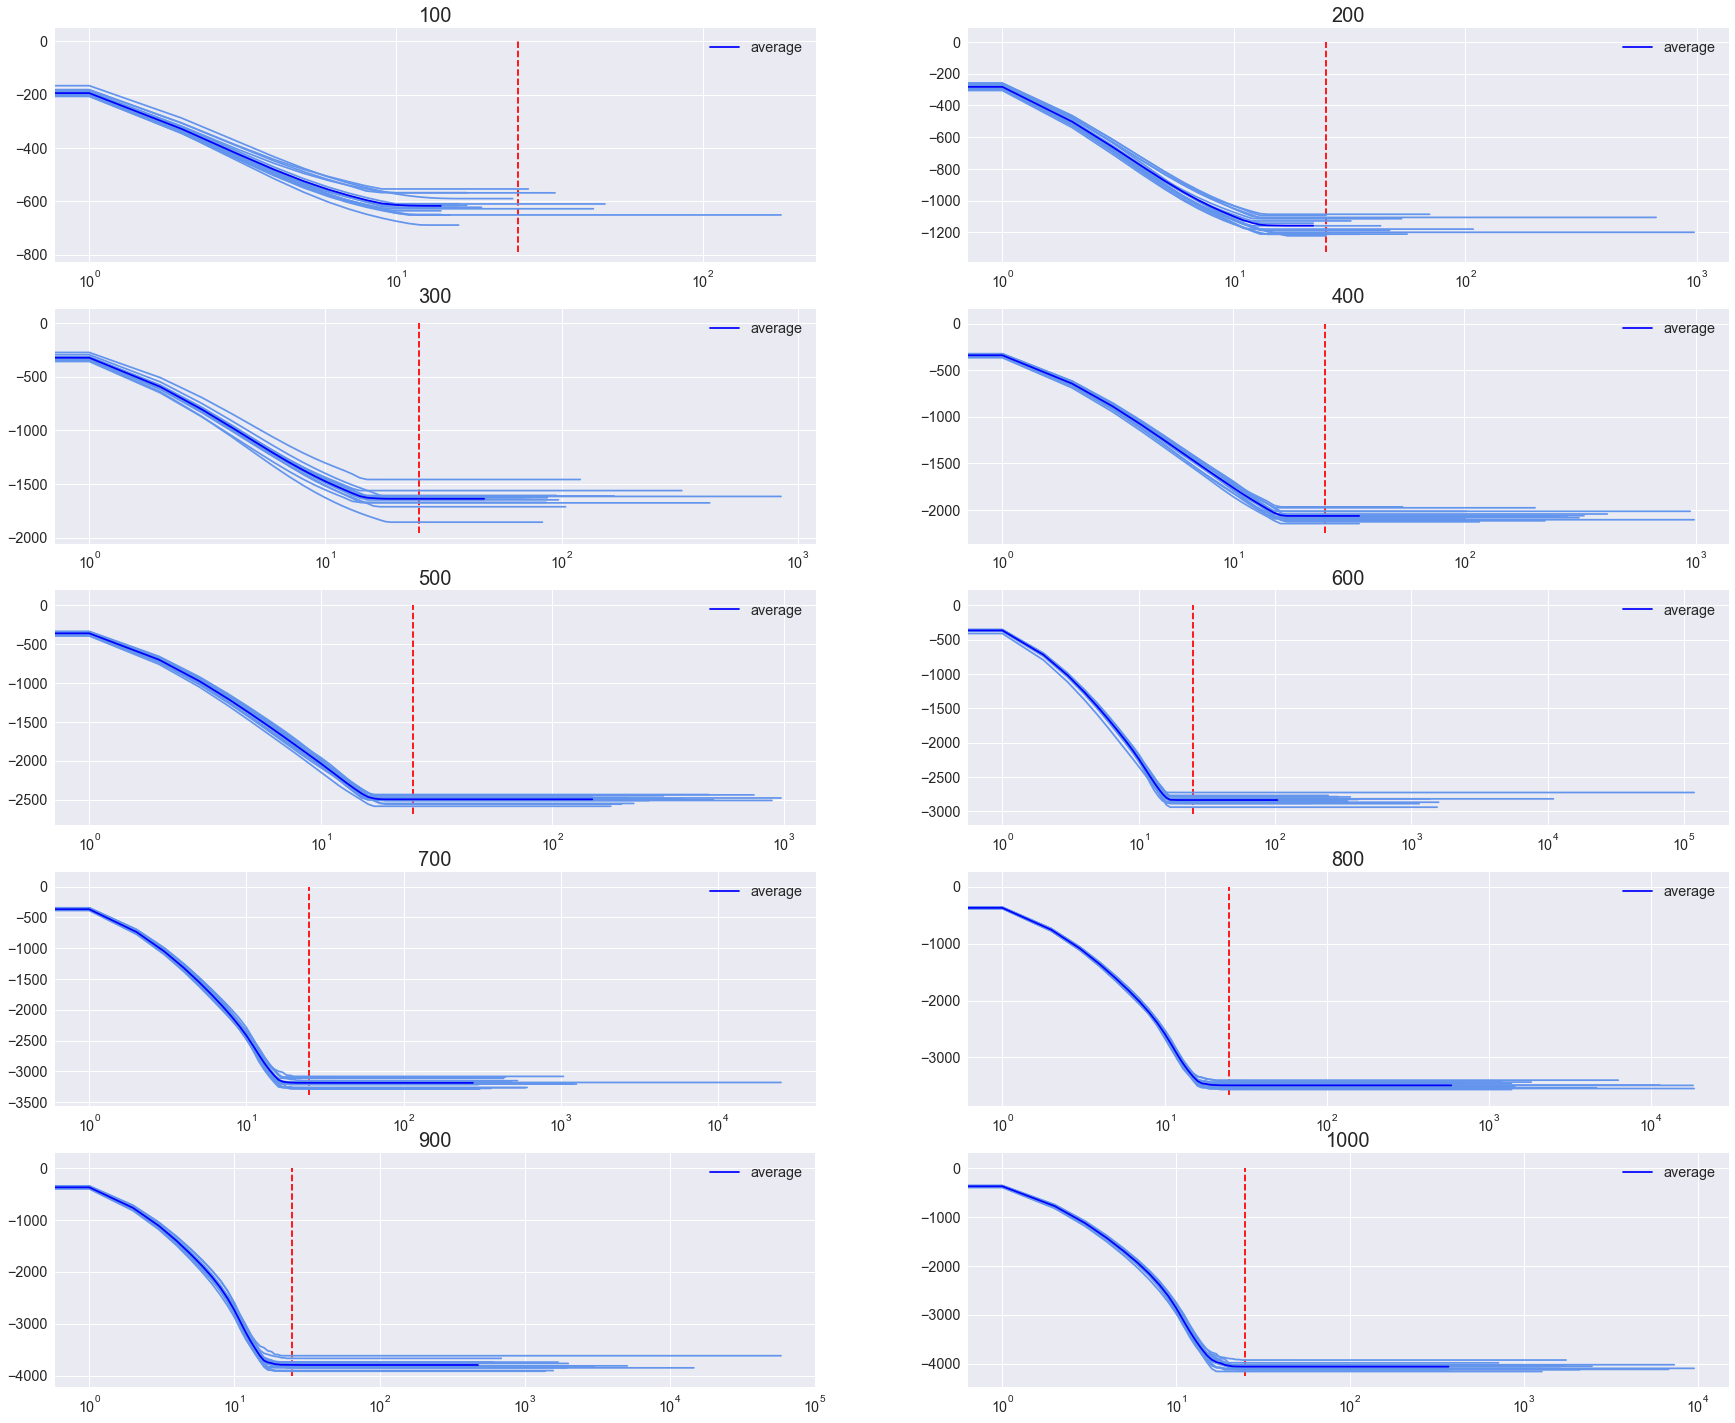

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,25))
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    values = load_problems_measure(str(size))
    plot_multiple_functions(values, plot_avg=True, ax=ax)
    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m = min([min(x) for x in values])
    ax.vlines(25, m-100, 0, label='25 iterations', colors='r', linestyles='dashed')

# Rosen

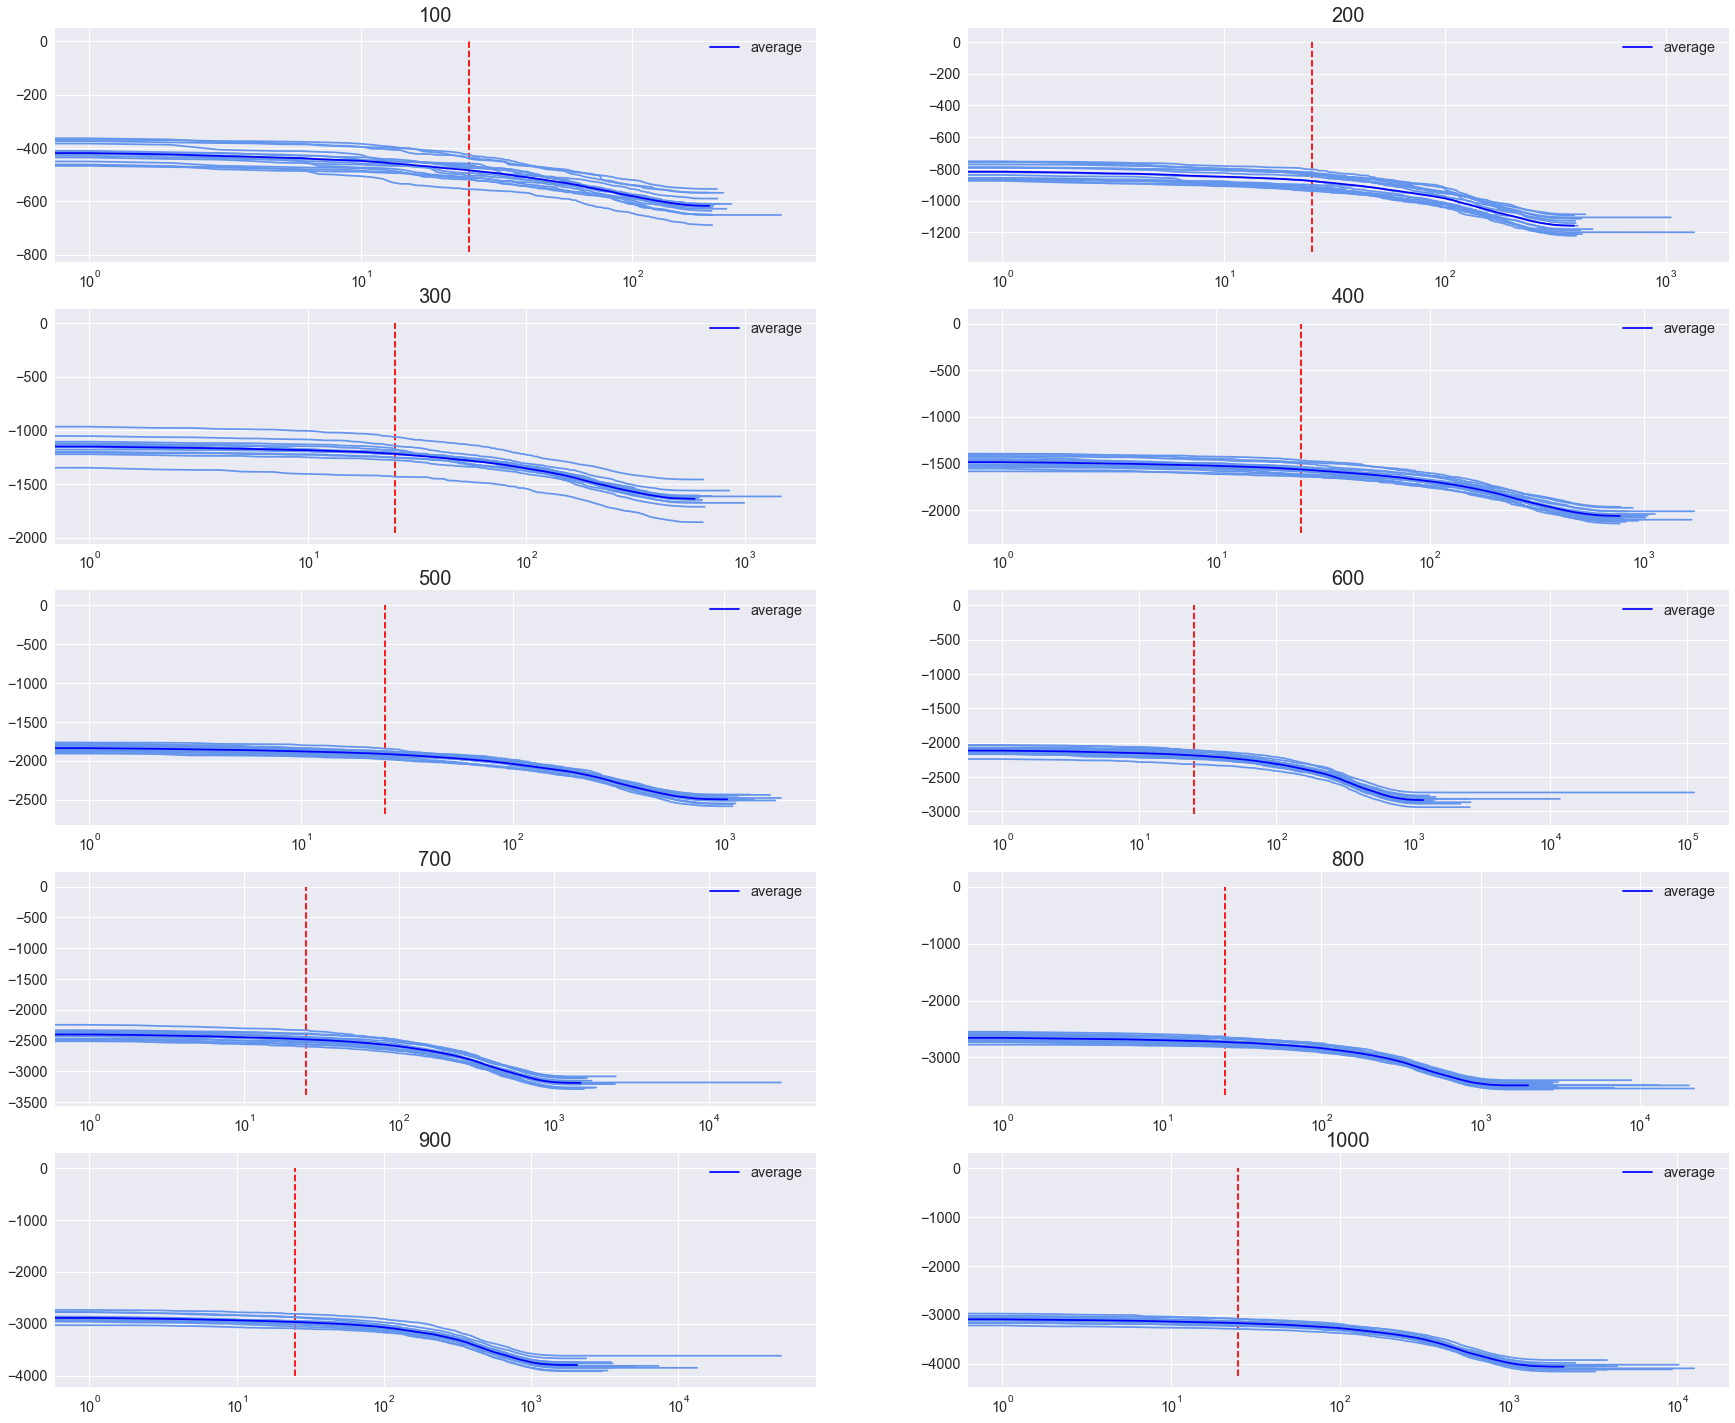

In [11]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,25))
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    values = load_problems_measure(str(size), alg="rosen")
    plot_multiple_functions(values, plot_avg=True, ax=ax)
    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m = min([min(x) for x in values])
    ax.vlines(25, m-100, 0, label='25 iterations', colors='r', linestyles='dashed')

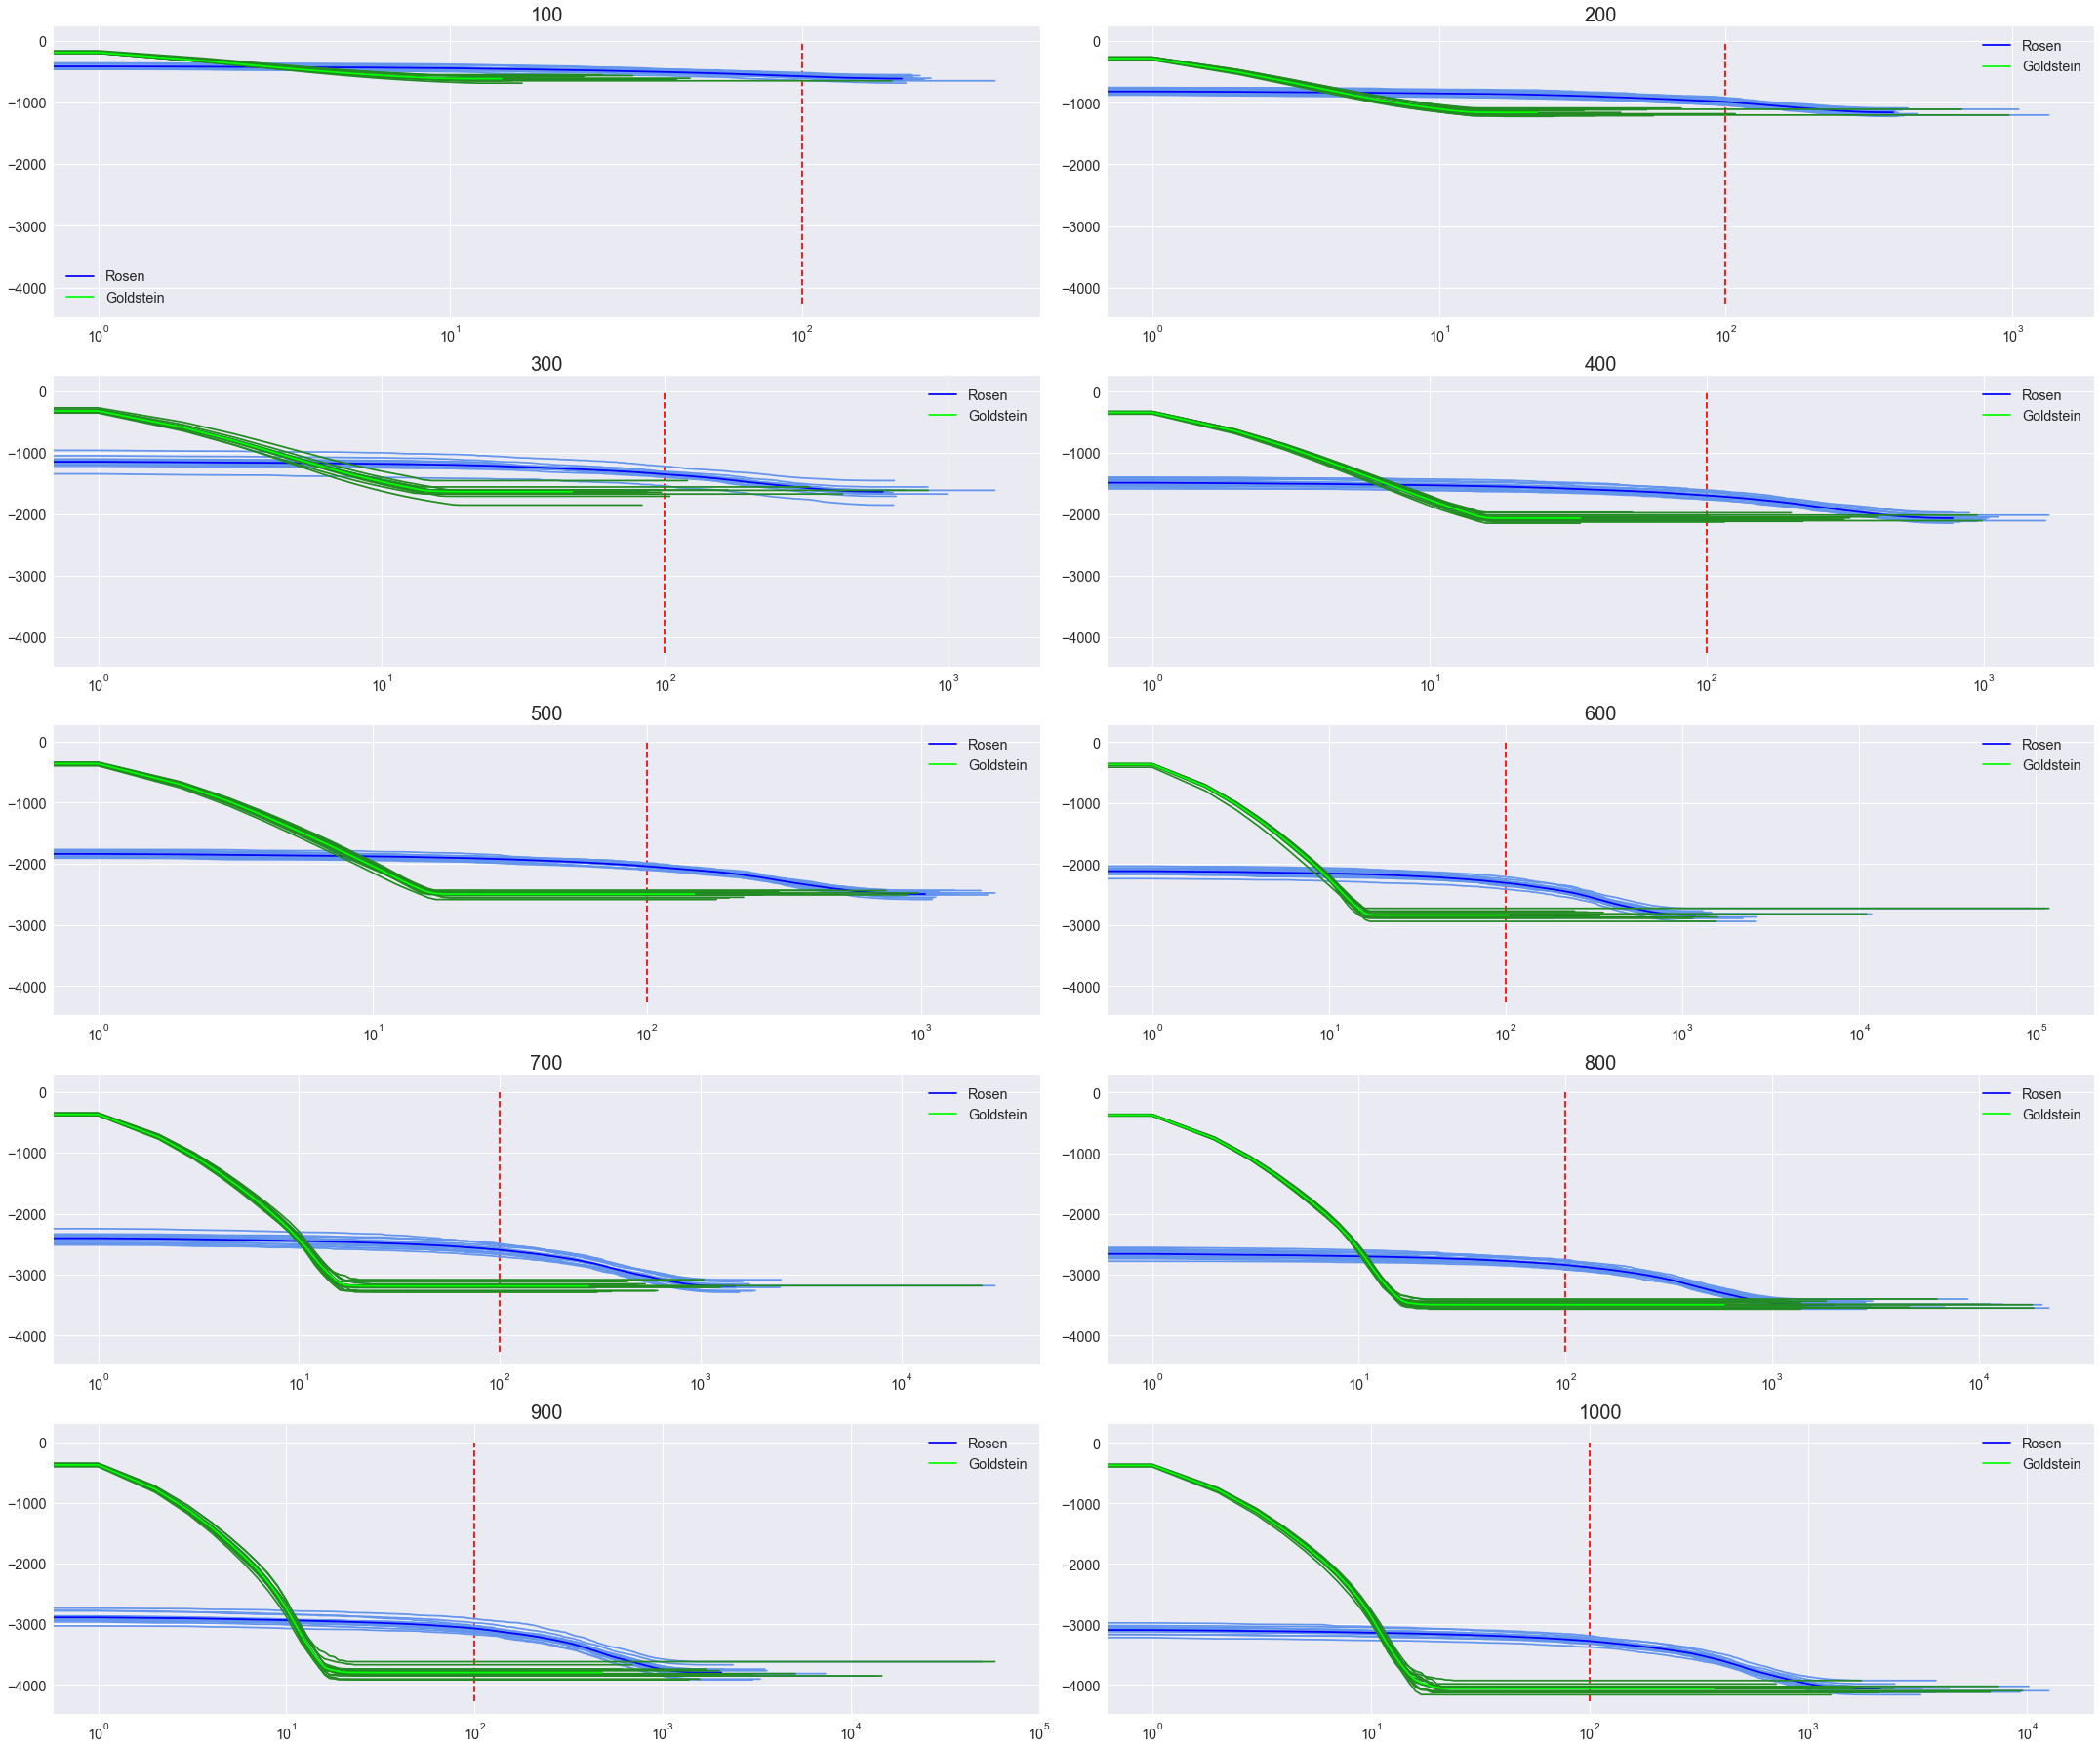

In [12]:

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,25))
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    values_rosen = load_problems_measure(str(size), alg="rosen")
    values_goldstein =  load_problems_measure(str(size), alg="goldstein")
    plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
    plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")

    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m = min([min(x) for x in values])
    ax.vlines(100, m-100, 0, label='25 iterations', colors='r', linestyles='dashed')
plt.tight_layout()

# Convergenza

In [13]:
def convergence(values, optimal_values):
    tmp = values - optimal_values
    res = []
    for l in tmp:
        res.append(l[1:] / l[:-1])
    return np.array(res)

In [14]:
size = 1000

In [15]:
values_goldstein = load_problems_measure(str(size), alg="goldstein")

In [16]:
values_rosen = load_problems_measure(str(size), alg="rosen")

In [17]:
convergence_gold_1000 = convergence(values_goldstein, np.array([v[-1] for v in values_goldstein]).flatten())
convergence_ros_1000 = convergence(values_rosen, np.array([v[-1] for v in values_rosen]).flatten())

<ipython-input-13-2b1bab7ecb50>:5: RuntimeWarning: divide by zero encountered in true_divide
  res.append(l[1:] / l[:-1])
<ipython-input-13-2b1bab7ecb50>:5: RuntimeWarning: invalid value encountered in true_divide
  res.append(l[1:] / l[:-1])


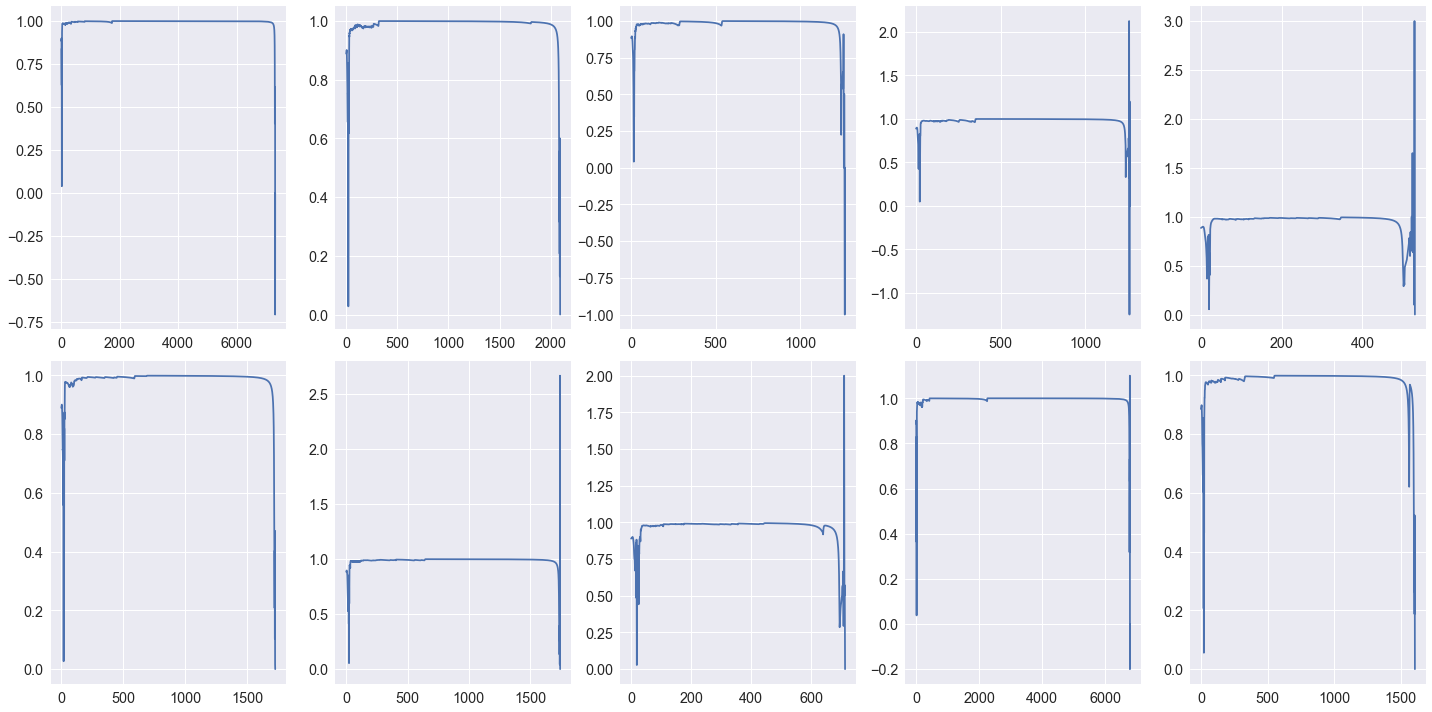

In [18]:
fig, ax = plt.subplots(ncols=5, nrows=2)
for (problem, ax) in zip(convergence_gold_1000, fig.axes):
    ax.plot(problem)
plt.tight_layout()

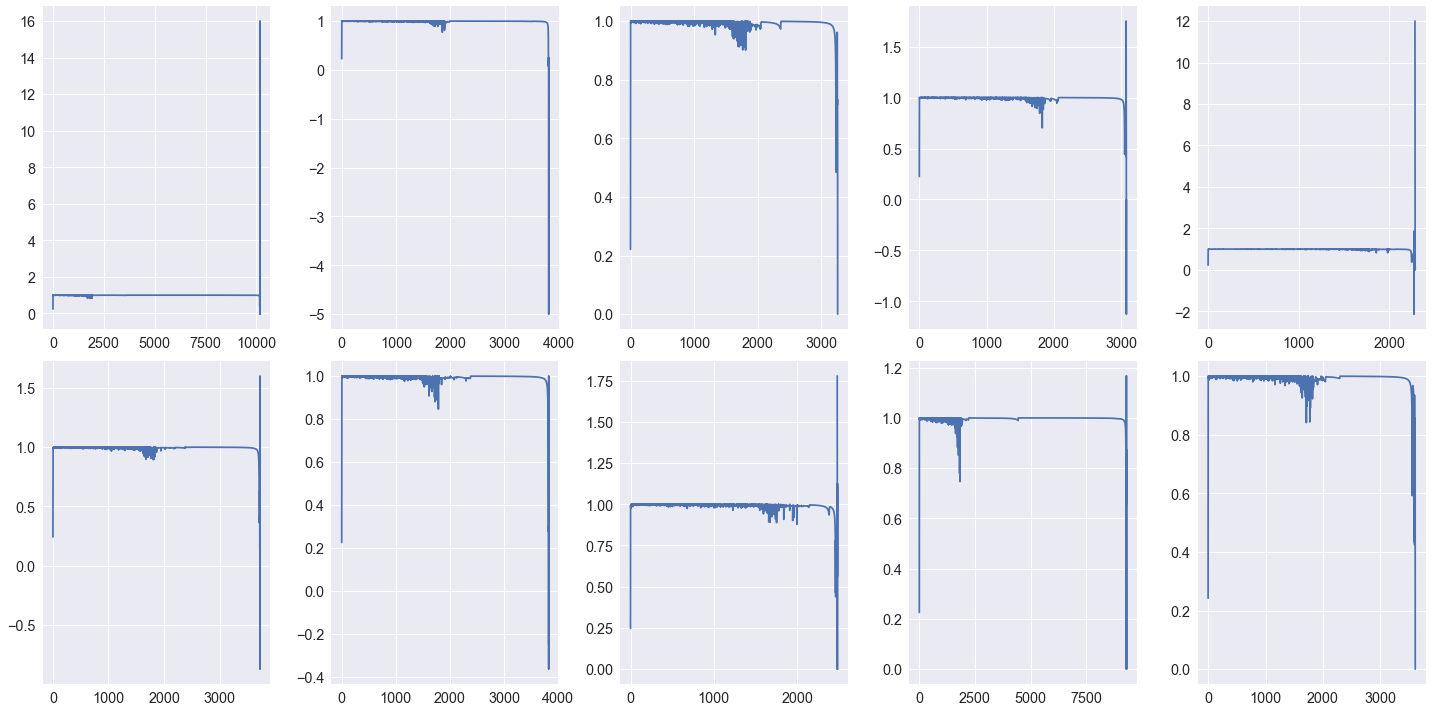

In [19]:
fig, ax = plt.subplots(ncols=5, nrows=2)
for (problem, ax) in zip(convergence_ros_1000, fig.axes):
    ax.plot(problem)
plt.tight_layout()